In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from glob import glob
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['hmnist_28_28_RGB.csv', 'ham10000_images_part_1', 'HAM10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_images_part_1', 'HAM10000_metadata.csv', 'hmnist_8_8_RGB.csv', 'hmnist_8_8_L.csv', 'ham10000_images_part_2']


In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import SaveModelCallback


In [4]:
import torch
print(torch.__version__)
import fastai
print(fastai.__version__)

1.0.1.post2
1.0.51


**Loading Data**

For the purposes of this notebook, we shall be concerning ourselves with only image classification. As such, we require to load the images within the dataset.

An easy way to do so is to utilise glob to get the path of each image. A dict will be created with the key being each image name and the value the relative path to that image. This dict will become useful in comprising the dataframe we shall be working from later.

When working with images, it is advised to convert the labels into a one-hot encoding to allow for the model to perform better at its task of prediction. To do so, we will create a dict of the various legion types, with the used shorthand as their key and the actual type of lesion as the value.

This dict will serve as the means to which we will carry out one hot encoding.

In [5]:
image_dir = "../input"

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(image_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

With the dicts defined, let's create the dataframe that we will be utilising going forward. The metadata required to comprise the dataset is to be found in HAM10000_metadata.csv, so let's load that and get to work.

In [6]:
image_dataframe = pd.read_csv(os.path.join(image_dir, 'HAM10000_metadata.csv'))
image_dataframe.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Now we know what we're working with, it would serve us better to create a few columns which are derived from our dicts defined earlier.

Firstly, we shall create the column *path* whose data shall be a mapping from the associated image_id to the respective value in imageid_path_dict.

Secondly, we shall create the column *cell_type* whose data will be, like *path* above, a mapping between the *dx* column and the lesion_type_dict.

Finally, we shall create the column *cell_type_dx* which will be the categorical representation of the various cell types.
Specifically, the lesion categories will be represented as:

* 'nv': 0
* 'mel': 1
* 'bkl': 2
* 'bcc': 3
* 'akiec': 4
* 'vasc': 5
* 'df': 6

In [7]:
image_dataframe['path'] = image_dataframe['image_id'].map(imageid_path_dict.get)
image_dataframe['cell_type'] = image_dataframe['dx'].map(lesion_type_dict.get) 
image_dataframe['cell_type_idx'] = pd.Categorical(image_dataframe['cell_type']).codes
image_dataframe.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


With the dataframe complete for our purposes, let's see what the distribution is for each lesion type.

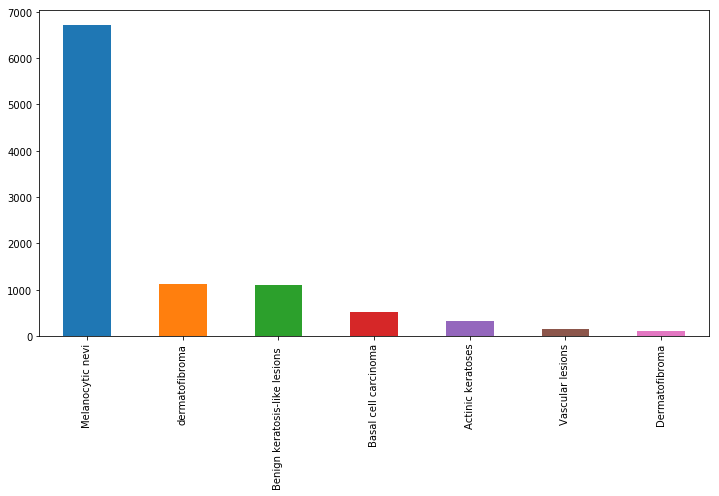

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = (12, 6))
image_dataframe['cell_type'].value_counts().plot(kind='bar', ax=ax)

As can be observed, there's a distinct bias towards Melanocytic nevi lesions within the dataset. This is to be expected given the commonality of these kind of lesions. 

It's time to comprise the image dataset! We shall concatenate two columns, *path* and *cell_type*, renaming the columns to *name* and *label* respectively.

In [9]:
image_dataset = pd.concat([image_dataframe['path'], image_dataframe['cell_type']], axis=1, keys=['name', 'label'])

image_dataset.head(5)

,name,label
0,../input/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions
1,../input/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions
2,../input/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions
3,../input/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions
4,../input/ham10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions


As we are utilising FastAI for this classifier, it provides us with the means to split and transform the dataset. From the [documentation](http://https://docs.fast.ai/vision.transform.html), get_transforms

> returns a tuple of two list of transforms: one for the training set and one for the validation set (we don't want to modify the pictures in the validation set, so the second list of transforms is limited to resizing the pictures). This can be then passed directly to define a DataBunch object (see below) which is then associated with a model to begin training.

The resulting tuple from get_transforms is passed as the transformed dataset to [ImageDataBunch](http://https://docs.fast.ai/vision.data.html#ImageDataBunch).
ImageDataBunch utilises factory methods to create an instance of ImageDataBunch, so for this instance as we've created a data frame representation of our dataset, we shall utilise [from_df](http://https://docs.fast.ai/vision.data.html#ImageDataBunch.from_df) which allows us to create an ImageDataBunch from a DataFrame.

Subsequently, we normalise the data using imagenet_stats. In the fast.ai library we have imagenet_stats, cifar_stats and mnist_stats so we can add normalization easily with any of these datasets.

In [10]:
bs = 64
size = 448

tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)
data = ImageDataBunch.from_df(".", image_dataset, ds_tfms=tfms, size=size, bs=bs).normalize(imagenet_stats)

Let's review a selection of the images in the dataset.

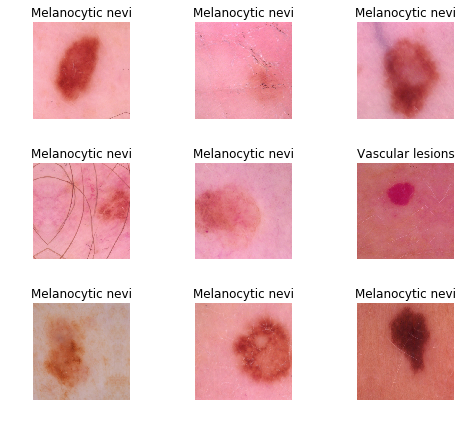

In [11]:
data.show_batch(rows=3, figsize=(7,6))

# Model Selection

For the purposes of this classification task, we shall utilise a convolutional neural network (CNN) which is perfectly suited to this task.
In respects to which particular model to utilise, instead of defining a model by ourselves and, more than likely, attempt to recreate what has already done by the field, we will utilise pretrained image classification models. Specifically, we shall utilise Resnet34, 50 and 161 to compare different complexity of neural network models to ascertain whether more neurons is better.

A brief overview on each Resnet mentioned above can be found here at [https://neurohive.io/en/popular-networks/resnet/](http://https://neurohive.io/en/popular-networks/resnet/)

**Training: resnet34**

With the data perpared for FastAI to be able to utilise, we can now start training our model. 
To do so, we will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier; in this case Resnet34 (All models selected can be found in torchvision's [API](https://pytorch.org/docs/stable/torchvision/models.html)

We will train for 4 epochs (4 cycles through all our data).

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])

In [17]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [18]:
learn.fit_one_cycle(10, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='skin-1')])


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.561642,0.985149,0.701448,0.298552,05:22
1,0.859465,0.620592,0.771842,0.228158,05:24
2,0.679687,0.562203,0.796306,0.203694,05:21
3,0.607174,0.512328,0.810784,0.189216,05:24
4,0.534291,0.473997,0.825262,0.174738,05:23
5,0.489409,0.444276,0.833749,0.166251,05:23
6,0.448040,0.424705,0.844234,0.155766,05:23
7,0.418202,0.412512,0.847728,0.152272,05:29
8,0.410691,0.405227,0.853220,0.146780,05:26
9,0.393010,0.407238,0.846231,0.153769,05:23


In [19]:
learn.save('stage-1')

**Results**

Let's see what results we have got.

Firstly, we will discover which of the classes of cell type that the model had difficulty classifying.
Secondly, we will determine if what the model predicted was reasonable, i.e. the mistakes made were not naive. This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

interp.plot_top_losses(9, figsize=(15,11))

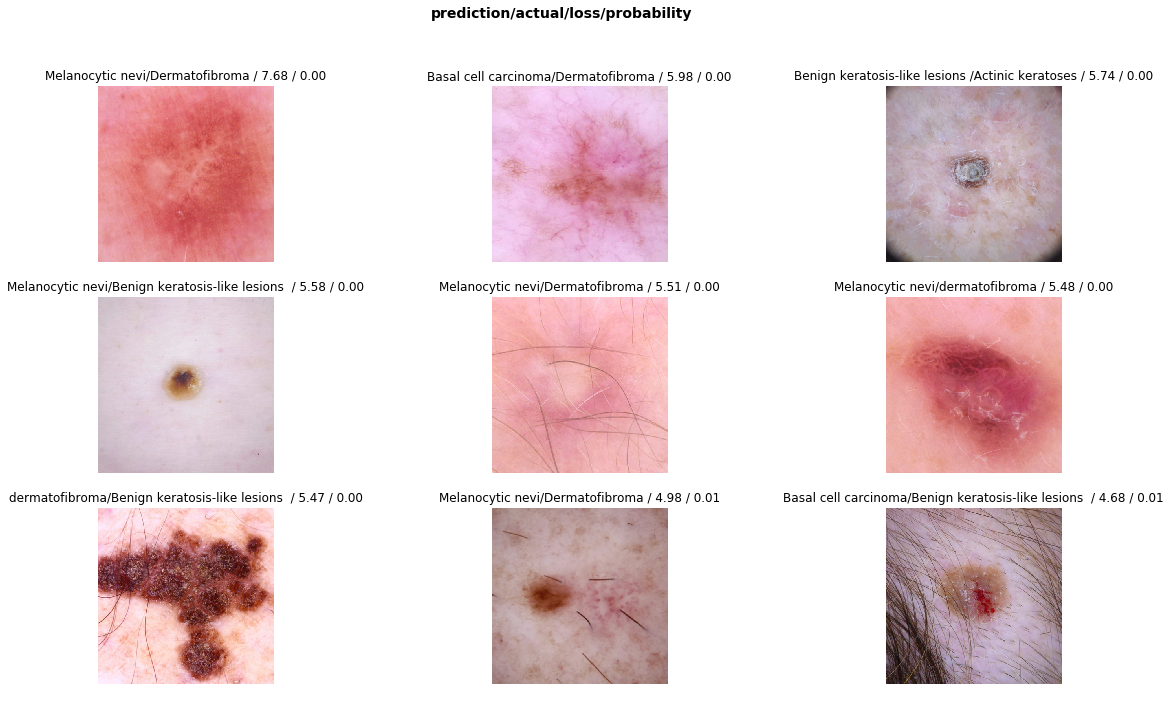

In [22]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=False)

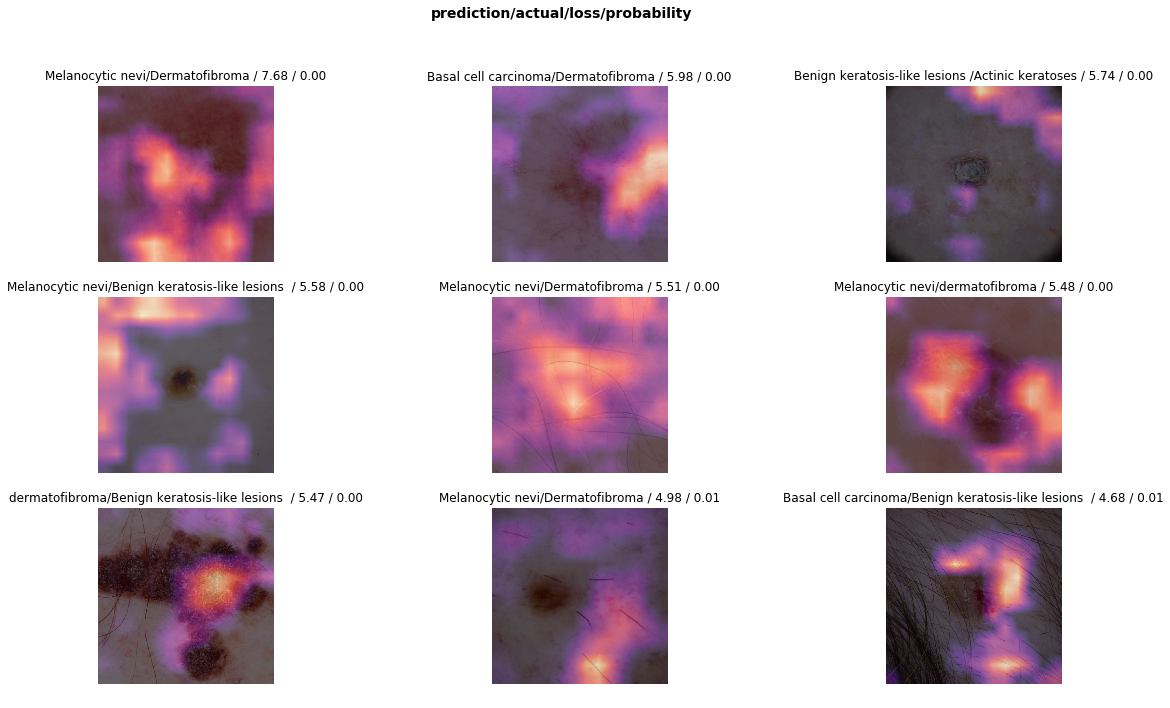

In [26]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

In [23]:
doc(interp.plot_top_losses)

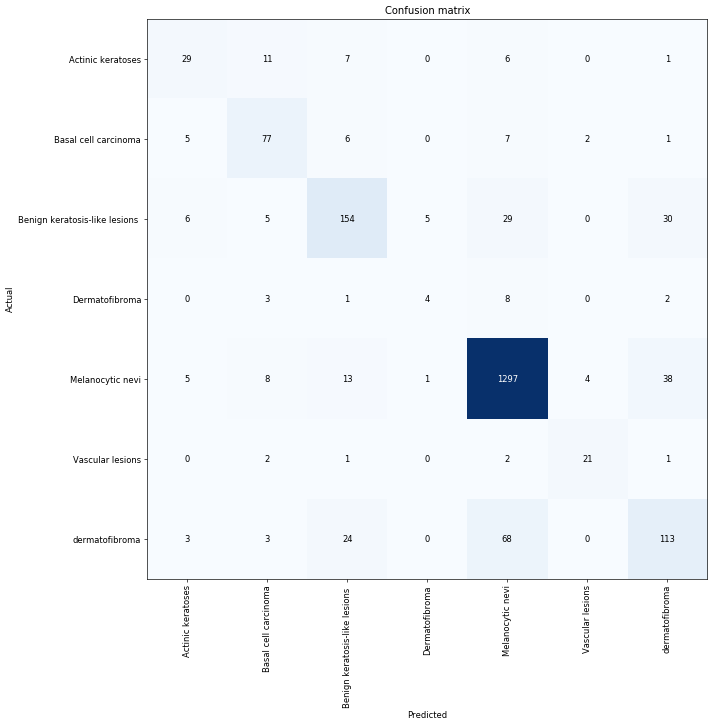

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(min_val=2)

[('dermatofibroma', 'Melanocytic nevi', 68),
 ('Melanocytic nevi', 'dermatofibroma', 38),
 ('Benign keratosis-like lesions ', 'dermatofibroma', 30),
 ('Benign keratosis-like lesions ', 'Melanocytic nevi', 29),
 ('dermatofibroma', 'Benign keratosis-like lesions ', 24),
 ('Melanocytic nevi', 'Benign keratosis-like lesions ', 13),
 ('Actinic keratoses', 'Basal cell carcinoma', 11),
 ('Dermatofibroma', 'Melanocytic nevi', 8),
 ('Melanocytic nevi', 'Basal cell carcinoma', 8),
 ('Actinic keratoses', 'Benign keratosis-like lesions ', 7),
 ('Basal cell carcinoma', 'Melanocytic nevi', 7),
 ('Actinic keratoses', 'Melanocytic nevi', 6),
 ('Basal cell carcinoma', 'Benign keratosis-like lesions ', 6),
 ('Benign keratosis-like lesions ', 'Actinic keratoses', 6),
 ('Basal cell carcinoma', 'Actinic keratoses', 5),
 ('Benign keratosis-like lesions ', 'Basal cell carcinoma', 5),
 ('Benign keratosis-like lesions ', 'Dermatofibroma', 5),
 ('Melanocytic nevi', 'Actinic keratoses', 5),
 ('Melanocytic nevi',

**Unfreezing, fine-tuning, and learning rates**

Since our model is working as we expect it to, we will unfreeze our model and train some more.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


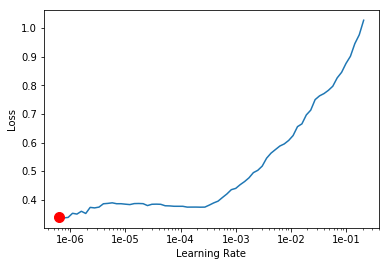

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [37]:
learn.unfreeze()
learn.fit_one_cycle(30, max_lr=slice(1e-4,1e-5), 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='skin-2')])
learn.save('skin-best')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.099300,0.251464,0.907639,0.092361,05:05
1,0.090325,0.241508,0.913130,0.086870,05:01
2,0.087958,0.246725,0.912132,0.087868,05:10
3,0.091415,0.258033,0.909636,0.090364,05:01
4,0.090400,0.265322,0.913630,0.086370,04:58
5,0.092824,0.322909,0.888667,0.111333,04:57
6,0.102716,0.346315,0.880180,0.119820,04:56
7,0.104106,0.351302,0.871692,0.128308,04:56
8,0.100924,0.309274,0.897654,0.102346,05:01
9,0.100210,0.395445,0.881678,0.118323,04:56


RuntimeError: write(): fd 84 failed with No space left on device

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=False)

In [ ]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

In [ ]:
doc(interp.plot_top_losses)

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

In [ ]:
learn.export('final.pkl')